# Activity Classifier

We've explored the data, examined the literature, chosen our features, and pre-processed all the data. Now it's time to finally build the classifier!

Import some of the libraries that we will need

In [1]:
import os

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal
import scipy.stats

import activity_classifier_utils

Load the data

In [2]:
fs = 256
data = activity_classifier_utils.LoadWristPPGDataset()

### Feature Extraction

Train on 10 second long non-overlapping windows

In [3]:
window_length_s = 10
window_shift_s = 10

In [4]:
import activity_classifier_utils

window_length = window_length_s * fs
window_shift = window_shift_s * fs
labels, subjects, features = [], [], []
for subject, activity, df in data:
    for i in range(0, len(df) - window_length, window_shift):
        window = df[i: i + window_length]
        accx = window.accx.values
        accy = window.accy.values
        accz = window.accz.values
        features.append(activity_classifier_utils.Featurize(accx, accy, accz, fs=fs))
        labels.append(activity)
        subjects.append(subject)

In [5]:
labels = np.array(labels)
subjects = np.array(subjects)
features = np.array(features)

## Build a Random Forest Classifier using sklearn

If you've done machine learning in Python before, you've more than likely used `sklearn`. ML for wearable data is no different. Let's use sklearn to train a random forest to classify our data.

In [6]:
from sklearn.ensemble import RandomForestClassifier

### Define hyperparameters

Let's build a forest with 100 trees where each tree has a maximum depth of 4

In [7]:
n_estimators = 100
max_tree_depth = 4

### Build and train the model

In [8]:
clf = RandomForestClassifier(n_estimators=n_estimators,
                             max_depth=max_tree_depth,
                             random_state=42)
clf.fit(features, labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

## Performance Evaluation

### Confusion Matrix

One way to evaluate the performance of a multi-class classifier is to look at a confusion matrix. The confusion matrix shows how many datapoints were misclassified and what they were misclassified as.

In [9]:
from sklearn.metrics import confusion_matrix

Confusion matrix, without normalization
[[0 1 0]
 [1 1 0]
 [0 0 1]]


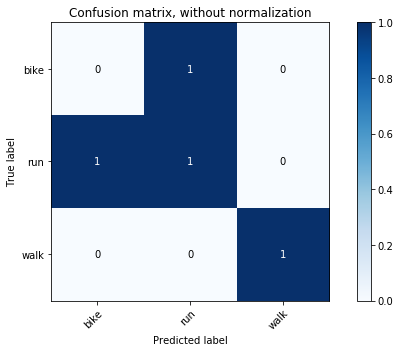

In [10]:
y_true = ['bike', 'run', 'run', 'walk']
y_pred = ['run', 'run', 'bike', 'walk']
class_names = ['bike', 'run', 'walk']
cm = confusion_matrix(y_true, y_pred, labels=class_names)
activity_classifier_utils.PlotConfusionMatrix(cm, class_names)

### Leave-One-Subject-Out Cross Validation

You may have seen leave-one-out cross validation. Leave-one-subject-out cross validation is similar.

For many biomedical signal applications you have many datapoints per subject. In this case we have 611 datapoints from only 8 subjects. Because there might be a lot of similarity in how an individual performs a specific activity, leaving some of that person's data in the training set and then testing on it might lead us to believe our model generalizes better than it actually would if it encounters a brand new person who it has never seen in the training set. 

For this reason we do leave-one-subject-out cross validation.  This is why we kept track of which subject each datapoint belonged to in the `subjects` array.

In [11]:
from sklearn.model_selection import LeaveOneGroupOut

In [12]:
class_names = np.array(['bike', 'run', 'walk'])
logo = LeaveOneGroupOut()
cm = np.zeros((3, 3), dtype='int')

In [13]:
for train_ind, test_ind in logo.split(features, labels, subjects):
    # For each cross-validation fold...
    
    # Split up the dataset into a training and test set.
    # The test set has all the data from just one subject
    X_train, y_train = features[train_ind], labels[train_ind]
    X_test, y_test = features[test_ind], labels[test_ind]
    
    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Run the classifier on the test set
    y_pred = clf.predict(X_test)
    
    # Compute the confusion matrix for the test predictions
    c = confusion_matrix(y_test, y_pred, labels=class_names)
    
    # Aggregate this confusion matrix with the ones from previous
    # folds.
    cm += c

### Plot Confusion Matrices

In [14]:
class_names = ['bike', 'run', 'walk']

Confusion matrix, without normalization
[[140   1 104]
 [  2 142   3]
 [ 13  18 188]]


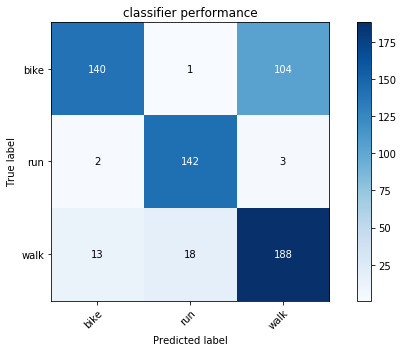

In [15]:
activity_classifier_utils.PlotConfusionMatrix(cm, class_names,
                                              title='classifier performance', normalize=False)

Normalized confusion matrix
[[ 0.57142857  0.00408163  0.4244898 ]
 [ 0.01360544  0.96598639  0.02040816]
 [ 0.05936073  0.08219178  0.85844749]]


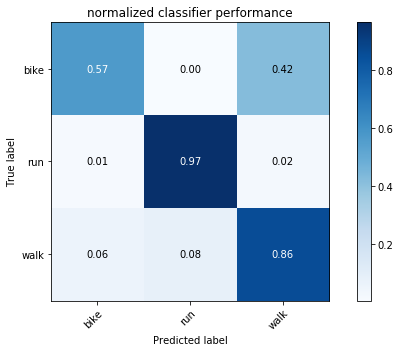

In [16]:
activity_classifier_utils.PlotConfusionMatrix(cm, class_names, 
                                              title='normalized classifier performance',
                                              normalize=True)

We seem to be really good at classifying `run`. We don't really mistake `run` for either `bike` or `walk` and don't misclassify the other classes as `run` often.

Our biggest mistake seems to be misclassifying `bike` as `walk`. We do that 42% of the time.

### Compute Classification Accuracy

An overall measure of classifier performance is the classification accuracy. This is the percent of time that we make a correct classification. There are other metrics to evaluate classifier performance, and using a single metric can be misleading depending on your dataset. See the further resources section for this lesson to learn more.

We can compute the classification accuracy from the confusion matrix as follows

In [17]:
print(np.sum(np.diag(cm)) / np.sum(np.sum(cm)))

0.769230769231


We've build an activity classifier. This is a good first step. Can we do better?